In [1]:
import warnings
warnings.filterwarnings("ignore")
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import pyplot
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
 
df= pd.DataFrame(data= np.c_[iris['data'], iris['target']], # np.c_ -->> concatenation along the second axis
                 columns= iris['feature_names'] + ['target'])


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
X = df.drop(["target"],axis=1).values
y = df["target"].values

In [5]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


In [7]:
class data_set: #  Dataset
    
    def __init__(self, variables, target): # variable and target as a numpy array
        
        self.variables = variables
        self.target = target
        
        self.variables = self.variables  #.astype(np.float32)
        self.target =  self.target  #.astype(np.float32)
    
    def __getitem__(self, index):
        "returns an (x, y) pair"
        X = self.variables[index]
        y = self.target[index]
        return X, y
    
    def __len__(self):
        return len(self.variables)


In [8]:
batch_size = 32
train_data =  data_set(X_train, y_train) # train_data[5]
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [9]:
_X, _y = next(iter(train_dataloader))
print(f"X shape: {_X.shape}")
print(f"y shape: {_y.shape}")

X shape: torch.Size([32, 4])
y shape: torch.Size([32])


In [10]:
test_data =  data_set(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
_X, _y = next(iter(train_dataloader))
print(f"X shape: {_X.shape}")
print(f"y shape: {_y.shape}")

X shape: torch.Size([32, 4])
y shape: torch.Size([32])


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = nn.functional.softmax(out, dim=1)
        return out


In [12]:
model = NeuralNetwork(input_dim=4, hidden_dim1=30, hidden_dim2=10, output_dim=3)

print(model)

NeuralNetwork(
  (fc1): Linear(in_features=4, out_features=30, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


In [13]:
learning_rate = 0.1
# loss_fn = nn.BCELoss() #binary crossentropy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #stochastic gradient descent

In [14]:
model(_X).shape
# _y.unsqueeze(-1)

torch.Size([32, 3])

In [15]:
# import state
num_epochs = 100
loss_values = []
batch_num = 0

accuracy_list = np.zeros((num_epochs,))
X_test, y_test = next(iter(test_dataloader))

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        
        #calculate the loss
        # loss = loss_fn(pred, y.unsqueeze(-1))
        loss = loss_fn(pred, y)
        
        loss_values.append(loss.item())
        loss.backward()
        
        #update the weights
        optimizer.step()
        if epoch == 0:
            batch_num += 1
            print('division of dataset to batch size')
        
    # Test
    with torch.no_grad():    
        output_test = model(X_test)
        correct = (torch.argmax(output_test, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

        
        
print("Training Complete")

"""
Training Complete
"""

division of dataset to batch size
division of dataset to batch size
division of dataset to batch size
division of dataset to batch size
Training Complete


'\nTraining Complete\n'

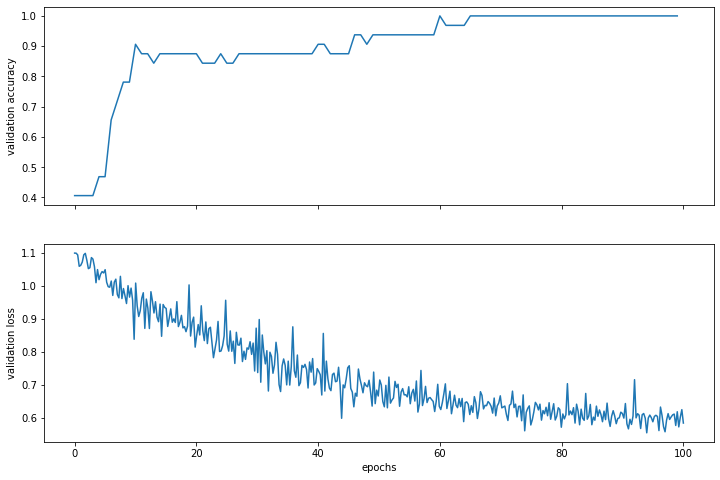

In [16]:
step = np.linspace(0, num_epochs, batch_num*num_epochs)
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(step, np.array(loss_values))
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

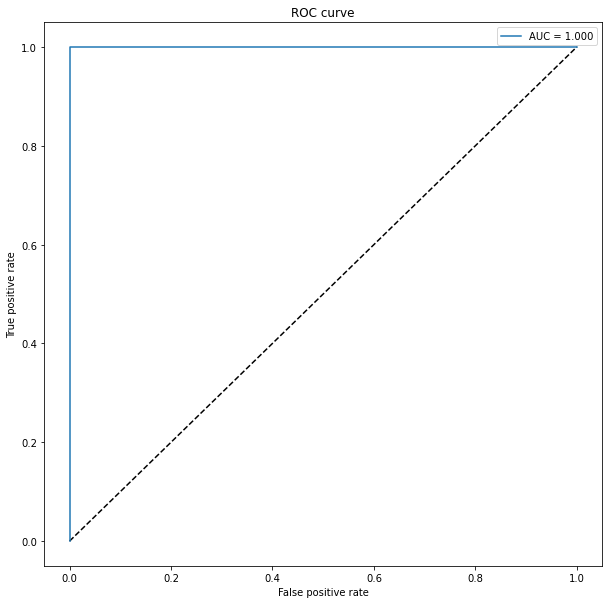

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();


